# SETUP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy, re
from connexion_db import *
from wordcloud import WordCloud

# Fonctions

In [2]:
def remove_emojis(input_text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251" 
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', input_text)

def supprimer_espaces_inutiles(chaine):
    # Utiliser une expression régulière pour remplacer les espaces multiples par un seul espace
    chaine_sans_espaces_inutiles = re.sub(r'\s+', ' ', chaine)
    return chaine_sans_espaces_inutiles.strip()  # Supprimer les espaces au début et à la fin de la chaîne

# Créer une fonction pour nettoyer le texte
def clean_text(text):
    # Supprimer les espaces blancs
    text = text.strip()
    # Supprimer les retours à la ligne
    text = text.replace('\n', ' ')
    # Supprimer les espaces inutiles
    text = supprimer_espaces_inutiles(text)
    # Supprimer les caractères spéciaux
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    # Supprimer les emojis
    text = remove_emojis(text)
    return text


# Traite du csv

In [3]:
nlp = spacy.load("en_core_web_sm")

# Load csv file
df = pd.read_csv('sample_data/Restaurant_reviews.csv', sep=',', encoding='utf-8')

# Insertion des restaurants en base de données
data = df.to_dict(orient='records')
add_restaurants(data, 'raw')

# delete columns that are not needed
df.drop(['Reviewer', 'Metadata', 'Time', 'Pictures','7514'], axis=1, inplace=True)

# delete rows where restaurant, rating, and review are missing
df.dropna(subset=['Restaurant', 'Rating', 'Review'], inplace=True)

# Appliquer la fonction de nettoyage au texte
df['Review'] = df['Review'].apply(clean_text)

# Conversion de la colonne Rating en type entier
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

conditions = [
    (df['Rating'].isin([1, 2])),  # Conditions pour les notes 1 et 2
    (df['Rating'] == 3),           # Condition pour la note 3
    (df['Rating'].isin([4, 5]))    # Conditions pour les notes 4 et 5
]

values = [0, 1, 2]  # Valeurs correspondantes pour chaque condition

df['Label'] = np.select(conditions, values)  # Créer une nouvelle colonne Label avec les valeurs correspondantes
df['Label'] = df['Label'].astype(int)  # Convertir la colonne Label en type entier

# affichage du nombre de labels
print(df['Label'].value_counts())

Label
2    6199
0    2564
1    1192
Name: count, dtype: int64


# Création du csv trains et test

In [4]:
# Create a new CSV file with cleaned data
df.to_csv('sample_data/reviews_test.csv', index=False)
print(df['Label'].value_counts())

# Insertion des restaurants en base de données
data = df.to_dict(orient='records')
add_restaurants(data, 'test')

Label
2    6199
0    2564
1    1192
Name: count, dtype: int64


In [5]:
# Create a new CSV with equal number of positive, negative and neutral reviews
df_negative = df[df['Label'] == 0].sample(1000) # 1000 negative reviews
df_neutral = df[df['Label'] == 1].sample(1000) # 1000 neutral reviews
df_positive = df[df['Label'] == 2].sample(1000) # 1000 positive reviews

df_balanced = pd.concat([df_positive, df_negative, df_neutral])

df_balanced.to_csv('sample_data/reviews_train.csv', index=False)
print(df_balanced['Label'].value_counts())

# Insertion en base de données

Label
2    1000
0    1000
1    1000
Name: count, dtype: int64


In [6]:
csv_train = 'sample_data/reviews_train.csv'

# Load csv file
df_train = pd.read_csv(csv_train, sep=',', encoding='utf-8')

# Insertion des restaurants en base de données
data = df_train.to_dict(orient='records')
add_restaurants(data, 'train')

nlp_data = pd.DataFrame({'text': df_train['Review'], "label": df_train['Label']}) 

#nlp_data

In [7]:
print("Check for missing values in Train dataset")
null_check=nlp_data.isnull().sum()
print(null_check)

Check for missing values in Train dataset
text     0
label    0
dtype: int64


In [8]:
for i in range(2):
    print(df_positive)

                           Restaurant  \
4848                   Udipi's Upahar   
8989              Mohammedia Shawarma   
2879                  Behrouz Biryani   
2040                         13 Dhaba   
1016         Sardarji's Chaats & More   
...                               ...   
5525                       Cafe Eclat   
9796  Zega - Sheraton Hyderabad Hotel   
5175        Hitech Bawarchi Food Zone   
6372                     Dine O China   
3770              Kritunga Restaurant   

                                                 Review  Rating  Label  
4848                                  delivered in time     5.0      2  
8989      Extra sauce we ordered and missed in package      4.0      2  
2879  Always at its best service or taste yummmmmmmm...     5.0      2  
2040  Great Food as always I have ordered multiple t...     5.0      2  
1016  Lods of Lods of Lods of Food Are you veg lover...     4.0      2  
...                                                 ...     ...    ..

In [9]:
for i in range(2):
    print(df_neutral)

                                 Restaurant  \
56                          Beyond Flavours   
5656       Feast - Sheraton Hyderabad Hotel   
1344          The Lal Street - Bar Exchange   
8155                               Delhi-39   
6757  Yum Yum Tree - The Arabian Food Court   
...                                     ...   
6609                           Aromas@11SIX   
9504                             Desi Bytes   
1066               Sardarji's Chaats & More   
2417                                  SKYHY   
6291  Shree Santosh Dhaba Family Restaurant   

                                                 Review  Rating  Label  
56    We went for lunch buffet yesterday and took a ...     3.0      1  
5656  Good food Nice hospitality Beautiful ambience ...     3.0      1  
1344  U can try just for different environment Food ...     3.0      1  
8155  Taste is ok ok but service is slow Usually ord...     3.0      1  
6757  Arabian touch to a sumptuous feast A great pla...     3.0      1

In [10]:
for i in range(2):
    print(df_negative)

                                Restaurant  \
8924                   Mohammedia Shawarma   
9981                      Chinese Pavilion   
9498                        Dunkin' Donuts   
1757                      Hotel Zara Hi-Fi   
8623                    The Chocolate Room   
...                                    ...   
2995                    Hunger Maggi Point   
9323              Zing's Northeast Kitchen   
9291  Collage - Hyatt Hyderabad Gachibowli   
4490            La La Land - Bar & Kitchen   
4744                       Shanghai Chef 2   

                                                 Review  Rating  Label  
8924  Sorry to say but got rotten tomato and cucumbe...     1.0      0  
9981  Chinese Cuisine including diverse styles from ...     4.5      0  
9498  Ate ma first donuts here They we re just amazi...     3.5      0  
1757                           The food was very spicy      2.0      0  
8623  Did not like the quality of chocolate ice crea...     2.0      0  
...      

In [11]:
nlp.Defaults.stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [12]:
#fonction qui prend en argument une review et qui en effectue le prétraitement nécessaire
#C'est à dire ne garder que les mots sauf les stopwords
def treat_comment(comment):
    spacy_comment = nlp(comment, disable=["parser", "ner", "textcat"])
    treated_tokens = [w.text for w in spacy_comment if w.is_alpha and not w.is_stop]
    return " ".join(treated_tokens)

clean_data = df_train['Review'].apply(treat_comment)

In [13]:
clean_data

0                                          delivered time
1                      Extra sauce ordered missed package
2              best service taste yummmmmmmmmmmmmmmmmyyyy
3       Great Food ordered multiple times favs includi...
4       Lods Lods Lods Food veg lover like paradise se...
                              ...                        
2995    visited place times year decent dine joint foo...
2996    place nice place recent times Live music affor...
2997    Located Indira nagar outlet serves chats limit...
2998    peri peri chicken dragon chicken starters Tast...
2999                           expected better raw spices
Name: Review, Length: 3000, dtype: object

In [14]:
data_plot = clean_data.groupby(df_train['Label']).count()

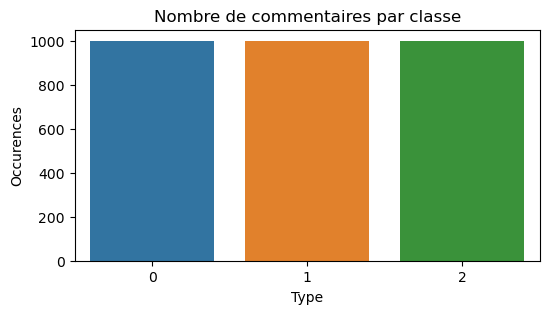

In [15]:
x = data_plot.reset_index()
#plot
plt.figure(figsize=(6,3))
ax= sns.barplot(x, x="Label", y="Review")
plt.title("Nombre de commentaires par classe")
plt.xlabel('Type')
plt.ylabel('Occurences')

plt.show()

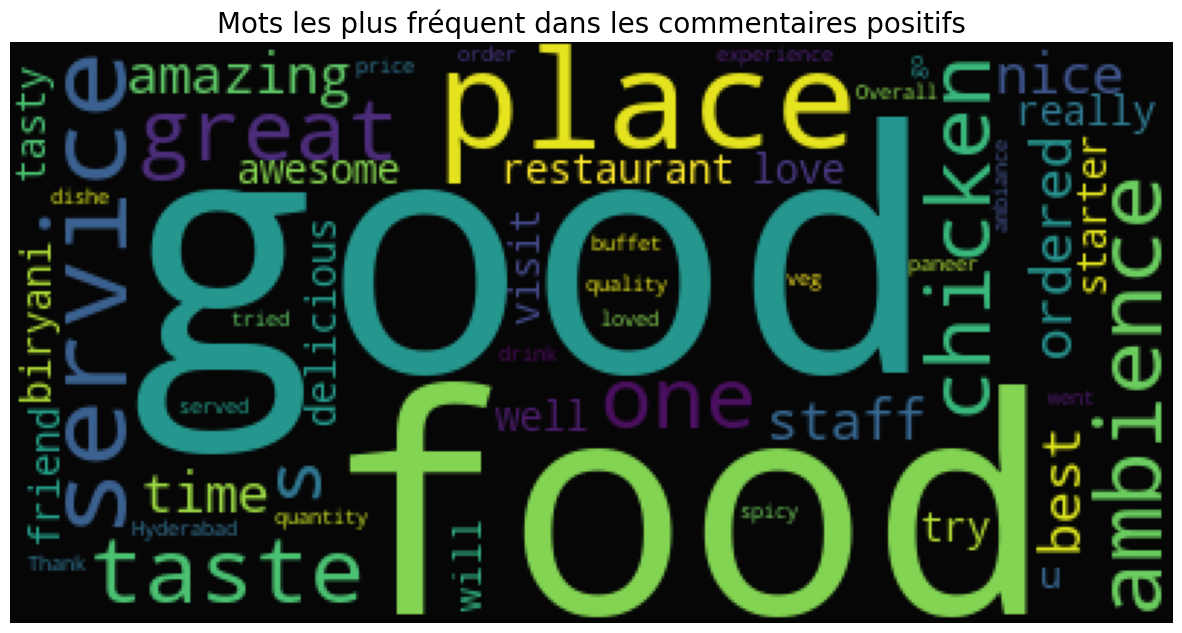

In [16]:
subnet = df_train[df_train['Label']==2]
text= subnet.Review.values
wc= WordCloud(background_color="black",max_words=50)
wc.generate(" ".join(text))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Mots les plus fréquent dans les commentaires positifs", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

In [17]:
subnet = df_train[df_train['Label']==1]
text= subnet.Review.values
wc= WordCloud(background_color="black",max_words=50)
wc.generate(" ".join(text))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Mots les plus fréquent dans les commentaires neutres", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

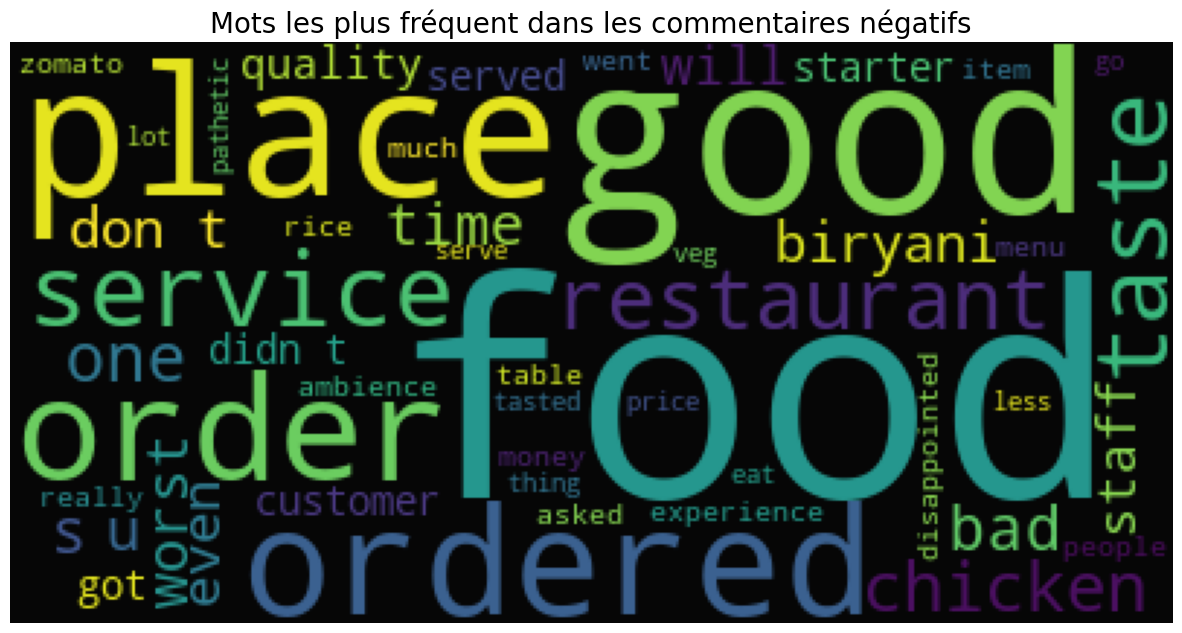

In [ ]:
subnet = df_train[df_train['Label']==0]
text= subnet.Review.values
wc= WordCloud(background_color="black",max_words=50)
wc.generate(" ".join(text))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Mots les plus fréquent dans les commentaires négatifs", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()